In [65]:
import torch
import math
from torch import nn
from end_to_end import train_model
from fault_dataset import AugmentedDataset, AugmentedDatasetTest, FaultDataset
from torch.utils.data import Dataset, DataLoader
from utils import collate_fn_transpose
import seaborn as sns

from models import TransformerModel_cls
params = {
    "batch_size": 1024,
    "epochs": 11000,
    "d_in": 3,
    "d_model": 140,
    "nhead": 20,
    "d_hid": 300,
    "nlayers": 6,
    "dropout": 0.3,
    "warmup": 4000,
    "seq_len": 40,
    "d_lin": 512,
    "d_out": 64,
    "freeze": False,
    "n_classes": 10,
    "lr_head": None,
    "model": "Transformer_cls",
    "path": None,
    "fourier": True,
    "margin": .05,
    "p_no_aug": .1,
    "p_two_aug": .5,
    "fold": 1,
}

model = TransformerModel_cls(  d_in = params["d_in"], 
                            d_model = params["d_model"], 
                            nhead = params["nhead"], 
                            d_hid = params["d_hid"],
                            nlayers = params["nlayers"], 
                            seq_len = params["seq_len"], 
                            dropout = params["dropout"])
train_dir = "data/5folddata/training_data_1"
test_dir = "data/5folddata/test_data_1"
train_dir_l = "data/5folddata/training_labels_1"
test_dir_l = "data/5folddata/test_labels_1"

p_no_aug = params["p_no_aug"]
p_two_aug = params["p_two_aug"]
batch_size = params["batch_size"]

test_data = AugmentedDatasetTest(fourier=False, data_path=test_dir, label_path=test_dir_l, downsample=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn = collate_fn_transpose)

x, y = next(iter(test_dataloader))
path = "models/fourier_no_aug/20230926-135705_acc_1"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

TransformerModel_cls(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=140, out_features=140, bias=True)
        )
        (linear1): Linear(in_features=140, out_features=300, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=300, out_features=140, bias=True)
        (norm1): LayerNorm((140,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((140,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=140, out_features=140, bias=True)
        )
    

In [66]:
x.shape

torch.Size([1600, 560, 1])

In [67]:
x = x.squeeze()

In [68]:
x = torch.transpose(x, 0, 1)

In [69]:
from utils import gaussian_noise

def signal_power(x):
    n = len(x)
    return torch.sum(torch.square(x))/n

def noisify(x, SNR):
    out = torch.zeros_like(x)

    L, n = x.shape
    den = 10**(SNR/10)

    for i in range(L):
        signal = x[i]
        Pn = signal_power(signal)/den
        out[i] = gaussian_noise(signal, std=Pn)

    return out

In [70]:
from utils import get_fourier_features

def fourier_iterate(x):
    x_fourier = torch.zeros((560, 40, 3))

    for i in range(len(x)):
        x_fourier[i] = get_fourier_features(x[i], k=40)
    return x_fourier

In [77]:
SNRs = [-8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
accs = []
model.cuda()

for SNR in SNRs:
    num_correct = 0
    x_noise = noisify(x, SNR)
    x_fourier = fourier_iterate(x_noise)
    x_fourier = torch.transpose(x_fourier, 0, 1).cuda()
    output = model(x_fourier).cpu()
    y_hat= torch.argmax(output, dim = 1)
    num_correct += (y_hat == y).sum()
    acc = num_correct/560
    accs.append(acc)

In [72]:
accs

[tensor(0.4250),
 tensor(0.4429),
 tensor(0.4804),
 tensor(0.5179),
 tensor(0.5768),
 tensor(0.6500),
 tensor(0.6911),
 tensor(0.6964),
 tensor(0.6911),
 tensor(0.7036)]

In [78]:
accs

[tensor(0.4143),
 tensor(0.4536),
 tensor(0.4679),
 tensor(0.5179),
 tensor(0.5732),
 tensor(0.6375),
 tensor(0.6661),
 tensor(0.6982),
 tensor(0.6929),
 tensor(0.7018)]

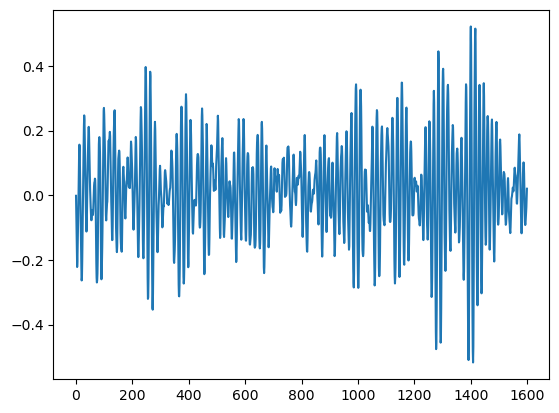

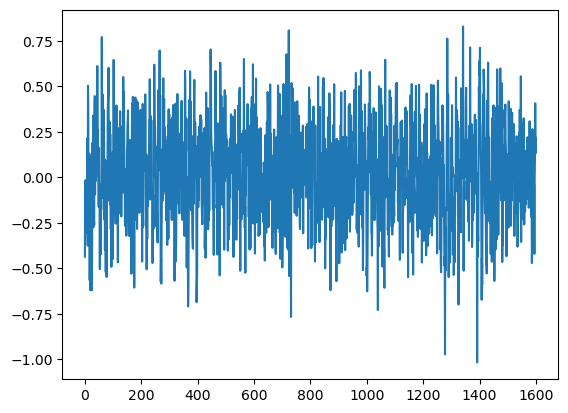

In [36]:
import matplotlib.pyplot as plt

time = torch.arange(1600)
plt.figure(0)
plt.plot(time, x[500])
plt.figure(1)
plt.plot(time, x_noise[500])

In [5]:
import math
def visualize_forward(model, x):
    src = model.embedding(x)*math.sqrt(model.d_model)
    src = model.cls(src)
    src = model.pos_encoder(src)
    return src

In [6]:
x_1 = x[:, 0, :].unsqueeze(1)
src = visualize_forward(model, x_1)

In [7]:
for name in model.state_dict():
    print(name, '\t', model.state_dict()[name].shape)

cls_token 	 torch.Size([1, 140])
pos_encoder.pe 	 torch.Size([500, 1, 140])
transformer_encoder.layers.0.self_attn.in_proj_weight 	 torch.Size([420, 140])
transformer_encoder.layers.0.self_attn.in_proj_bias 	 torch.Size([420])
transformer_encoder.layers.0.self_attn.out_proj.weight 	 torch.Size([140, 140])
transformer_encoder.layers.0.self_attn.out_proj.bias 	 torch.Size([140])
transformer_encoder.layers.0.linear1.weight 	 torch.Size([300, 140])
transformer_encoder.layers.0.linear1.bias 	 torch.Size([300])
transformer_encoder.layers.0.linear2.weight 	 torch.Size([140, 300])
transformer_encoder.layers.0.linear2.bias 	 torch.Size([140])
transformer_encoder.layers.0.norm1.weight 	 torch.Size([140])
transformer_encoder.layers.0.norm1.bias 	 torch.Size([140])
transformer_encoder.layers.0.norm2.weight 	 torch.Size([140])
transformer_encoder.layers.0.norm2.bias 	 torch.Size([140])
transformer_encoder.layers.1.self_attn.in_proj_weight 	 torch.Size([420, 140])
transformer_encoder.layers.1.self_a

In [8]:
s = nn.Softmax(dim=1)
def visualize_attn(w0, b0, src, head):
    '''
    w0: input projection, as defined by torch
    b0: input bias, as defined by torch
    src: source vector to calculate attention
    '''

    w0_t = torch.transpose(w0, 0,1)
    qkv = torch.matmul(src, w0_t)
    qkv = qkv+b0

    head_start = head*7
    head_end = head_start + 7
    q = qkv[:, :, :140].squeeze()
    k = qkv[:, :, 140:280].squeeze()
    v = qkv[:, : ,280:].squeeze()
    
    q_i = q[:, head_start:head_end]
    k_i = k[:, head_start:head_end]
    v_i = v[:, head_start:head_end]

    qk_t = torch.matmul(q_i, torch.transpose(k_i, 0, 1))
    qk_t = qk_t.detach()

    alpha = s(qk_t)

    return alpha.detach()


In [21]:
w0 = model.state_dict()["transformer_encoder.layers.0.self_attn.in_proj_weight"]
b0 = model.state_dict()["transformer_encoder.layers.0.self_attn.in_proj_bias"]

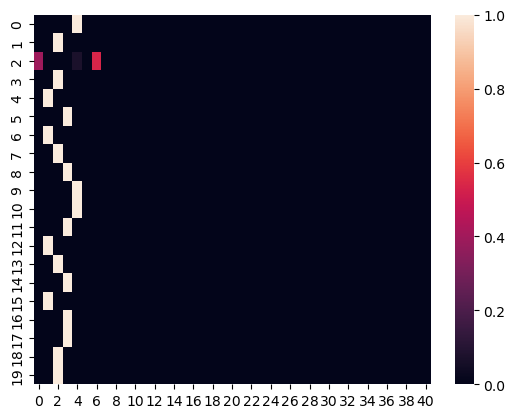

In [22]:
cls_attn = torch.zeros((20,41))
for i in range(20):
    attn_scores = visualize_attn(w0, b0, src, i)
    cls_attn[i, :] = attn_scores[0, :]
layer0_cls_attn = sns.heatmap(cls_attn)

In [23]:
layer0_cls_attn.set_title("Attention Scores from CLS token for Layer 0")
layer0_cls_attn.set(xlabel='Token', ylabel='Head')
layer0_cls_attn.get_figure().savefig("pics/acc_layer00_cls_attn.png")

In [32]:
labels = torch.argmax(y_hat, dim=1)

In [33]:
labels.shape

torch.Size([64])

In [6]:
x = x.cuda()
model.cuda()
y_hat = model(x)

RuntimeError: CUDA out of memory. Tried to allocate 786.00 MiB (GPU 0; 11.75 GiB total capacity; 1.69 GiB already allocated; 131.88 MiB free; 2.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

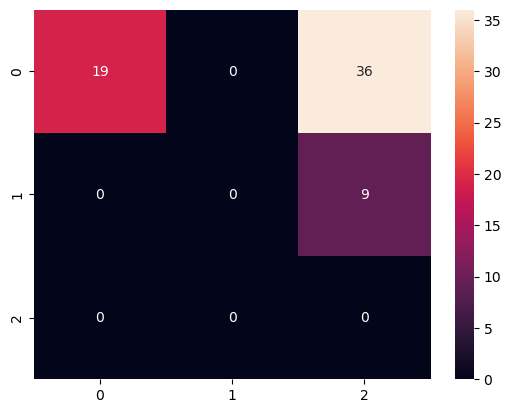

In [36]:
from sklearn.metrics import confusion_matrix
m = confusion_matrix(y, labels)
cf_matrix = sns.heatmap(m, annot=True)

In [120]:
fig = cf_matrix.get_figure()
cf_matrix.set_title("Confusion Matrix")
fig.savefig("pics/confusion.png") 

In [89]:
 def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [90]:
count_parameters(model)

985870

In [38]:
y_hat.shape

torch.Size([560, 10])

In [39]:
from tsnecuda import TSNE
import torch
import seaborn as sns

In [127]:
X_embedded = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(y_hat.detach())

WARNING clustering 560 points to 23 centroids: please provide at least 897 training points


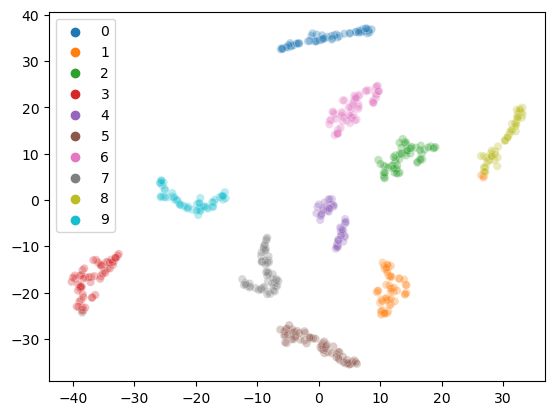

In [128]:
embed = sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=y,
    palette=sns.color_palette(),
    legend="full",
    alpha=0.3
)

In [129]:
embed.set_title('t-SNE Embedding on Test Set')

Text(0.5, 1.0, 't-SNE Embedding on Test Set')

In [130]:
fig = embed.get_figure()
fig.savefig("pics/tsne.png") 